# Wprowadzenie

Celem poniższego projektu jest przeprowadzenie analizy pytań z bazy pytań na prawo jazdy kategorii B, a także stworzenia modelu klasyfikacyjnego przewidującego odpowiedź na bazie treści pytania. 

Egzamin teoretyczny składa się z grafiki, pytania oraz możliwych odpowiedzi i składa się z 32 pytań:

* 20 pytań z wiedzy podstawowej, gdzie możliwe odpowiedzi to *Tak* lub *Nie* 

* 12 pytań z wiedzy specjalistycznej z odpowiedziami *A*, *B* lub *C*,

Wszystkie pytania są punktowane za 1, 2 lub 3 punkty, a do zdania potrzeba minimum 80% punktów. Pula pytań jest ogólnodostępna i na jej podstawie trenowany jest model.

W ramach uproszczenia postanowiłem zająć się wyłącznie pytaniami z części podstawowej oraz przyjąć założenie, że wszystkie pytania punktowane są tak samo. Moim celem jest stworzenie modelu predykcyjnego przewidującego poprawną odpowiedź i jego ewaluacja za pomocą miernika dokładności (ang. *accuracy*), a także stworzenia prostego i intuicyjnego drzewa decyzyjnego wspomagającego proces odpowiedzi w przypadku gdy jest ona nieznana. O ile wszystkie pytania posiadają grafiki, nie są one celem analizy. Analizowane są wyłącznie dane tekstowe - wszystkie pytania posiadają pomocniczy film lub grafikę, jednak nie są one przedmiotem analizy.

Kolejność analizy będzie następująca:

* eksploracyjna analiza danych
* modele na podstawie Bag od Words (BOW):
    * model drzew dezyzyjnych różnych głębokości
* modele na podstawie embeddingów
    * model fasttext


# Eksploracja i analiza danych

In [1]:
import pandas as pd

from src.data_transformer import DataTransformer

data_transformed = DataTransformer()
questions = data_transformed.load_data('data/questions.xlsx')
# questions = data_transformed.df

print(f"The dataset has {questions.shape[0]} rows and {questions.shape[1]} columns")

questions.head()


The dataset has 1666 rows and 2 columns


,question,answer
0,"Czy ten znak informuje o prędkości minimalnej,...",Nie
1,Czy w tej sytuacji znak pionowy „zakaz zatrzym...,Tak
2,Czy w tej sytuacji przed wykonaniem manewru sk...,Tak
3,Czy w tej sytuacji masz prawo wjechać na skrzy...,Nie
4,"Czy w tej sytuacji, skręcając w prawo, możesz ...",Nie


In [2]:
counts = questions.value_counts('answer')
proportions = questions.value_counts('answer', normalize=True).round(2)

pd.DataFrame({
    'Counts': counts,
    'Proportions': proportions
})

,Counts,Proportions
answer,,
Tak,903,0.54
Nie,763,0.46


Spośród wszystkich pytań, na 54% z nich poprawną odpowiedzią jest *Tak*, a na 46% *Nie*. W innych słowach – oznacza to, że jeżeli będziemy zgadywać odpowiedź i zaznaczymy odpowiedź *Tak* mamy 54% prawdopodobieństwa że trafimy.

## Wordcloud

Word cloud (chmura słów) to narzędzie do wizualizacji częstotliwości występowania słów w tekście lub w korpusie tekstów. Im częściej dane słowo pojawia się w tekście, tym większy jest jego rozmiar w chmurze słów, co pozwala szybko zidentyfikować najważniejsze lub charakterystyczne słowa w danym tekście lub zbiorze tekstów.

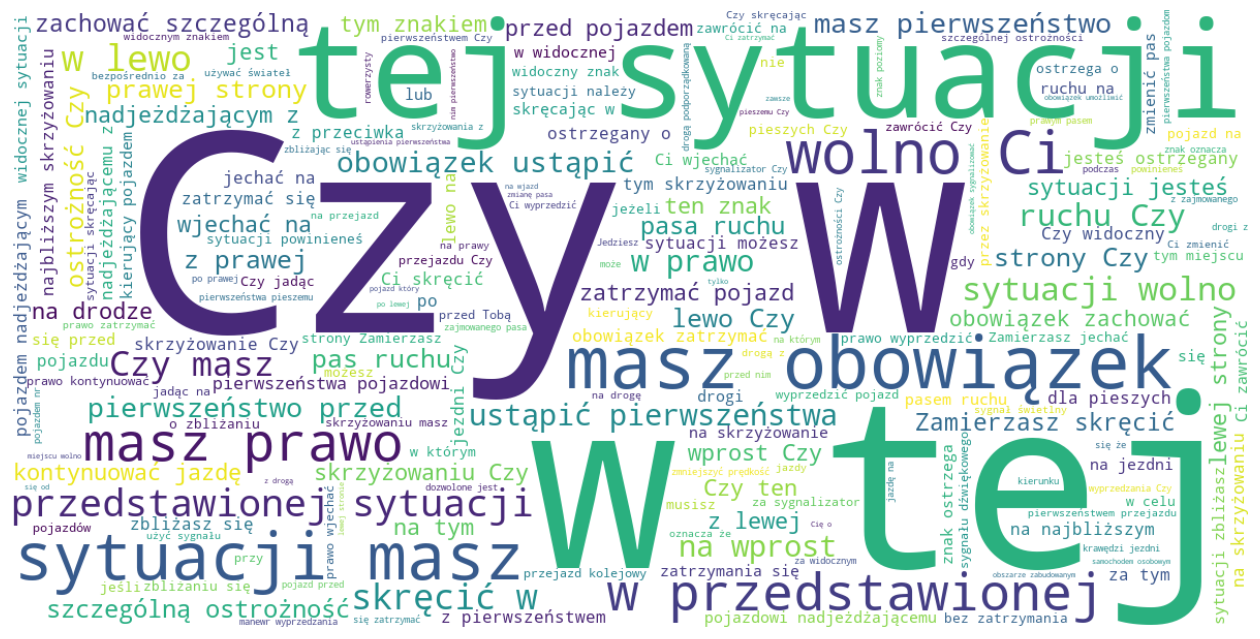

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

from utils.functions import generate_wordcloud

corpus = ' '.join(questions["question"])
    
generate_wordcloud(corpus)

Z powyższej chmury widać, że najczęściej pojawiają się słowa takie jak "czy", "w", "tej" - w nomenklaturze NLP są określa się je terminem **stopwords**. Stopwordami są najczęściej występujące słowa w języku. Na ogół nie niosą ze sobą żadnych istotnych treści, stąd można je bez negatywnych konsekwencji usunąć z korpusu. Jest to dobry moment na poddanie korpusu różnym transformacjom (nie tylko usunięciem stopwordów). Będą to:

* **lematyzacja** – sprowadzenie słowa do jego podstawowej formy. Przykładowo, wyrażenie *zachowanie szczególnej ostrożności* po lematyzacji przyjmie formę *zachować szczególna ostrożność*
* **usunięcie stopwordów**
* **usunięcie znaków interpunkcyjnych** – konieczne do dalszego procesowania słów

In [4]:
questions_transformed = data_transformed.preprocess_questions(questions)

questions_transformed.head()

100%|███████████████████████████████████| 1666/1666 [00:00<00:00, 271694.49it/s]


,original,lemmatized,no_stopwords,no_punctuation,answer
0,"Czy ten znak informuje o prędkości minimalnej,...","czy ten znak informować o prędkość minimalny ,...","znak informować prędkość minimalny , mieć praw...",znak informować prędkość minimalny mieć prawo...,Nie
1,Czy w tej sytuacji znak pionowy „zakaz zatrzym...,czy w ten sytuacja znak pionowy „ zakaz zatrzy...,sytuacja znak pionowy „ zakaz zatrzymywać ” do...,sytuacja znak pionowy „ zakaz zatrzymywać ” do...,Tak
2,Czy w tej sytuacji przed wykonaniem manewru sk...,czy w ten sytuacja przed wykonać manewr skręt ...,"sytuacja wykonać manewr skręt prawo , mieć obo...",sytuacja wykonać manewr skręt prawo mieć obow...,Tak
3,Czy w tej sytuacji masz prawo wjechać na skrzy...,czy w ten sytuacja mieć prawo wjechać na skrzy...,sytuacja mieć prawo wjechać skrzyżować zatrzym...,sytuacja mieć prawo wjechać skrzyżować zatrzymać,Nie
4,"Czy w tej sytuacji, skręcając w prawo, możesz ...","czy w ten sytuacja , skręcać w prawo , móc wje...","sytuacja , skręcać prawo , móc wjechać skrzyżo...",sytuacja skręcać prawo móc wjechać skrzyżowa...,Nie


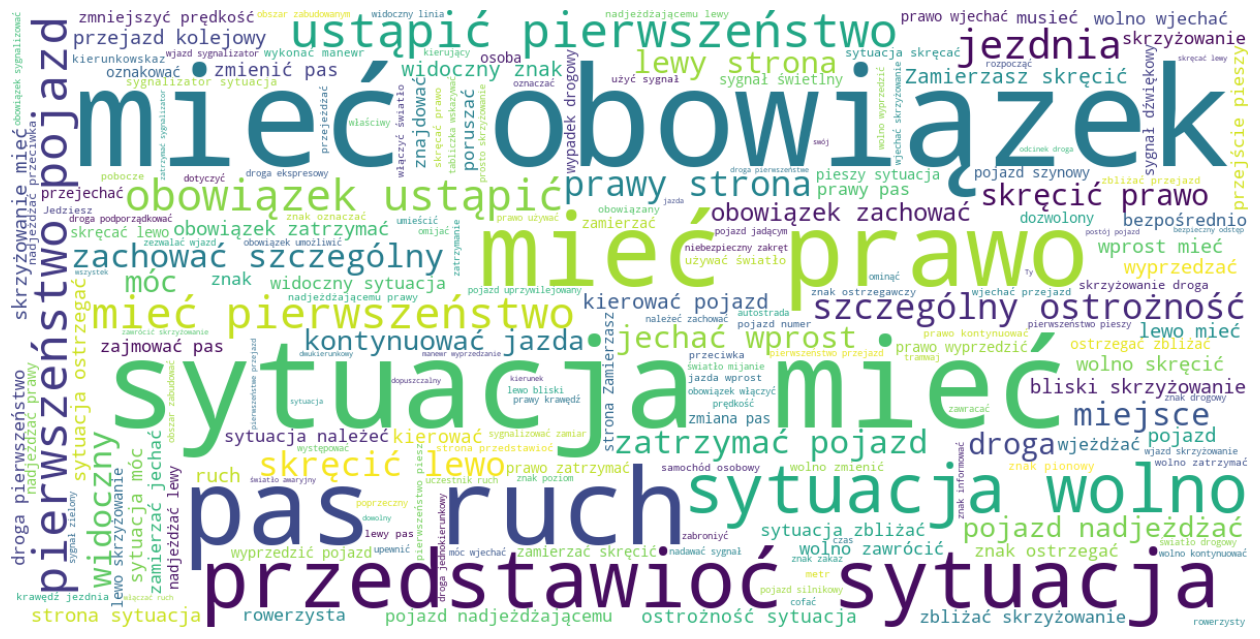

In [5]:
corpus = ' '.join(questions_transformed["no_punctuation"])

generate_wordcloud(corpus)

Powyższy wordcloud przedstawia już przeprocesowany korpus, który lepiej odzwierciedla najczęściej pojawiające się słowa. Czasami słowa przyjmują formy nieistniejące w polskim języku (np. *przedstawioć*) – jest to wynik niedoskonałego działania lematyzera, jednak takie wyrażenia wciąż są zrozumiałe.

## Reprezentacja Bag of Words (BoW)

Jedną z klasycznych metod przetwarzania języka naturalnego jest używanie reprezentacji **Bag of Words** (BoW). Jest to metoda analizy tekstu, która sprowadza tekst do zestawu słów i liczy, ile razy każde słowo występuje. Nie zwraca uwagi na kolejność słów, a jedynie na ich częstość. Na przykład, zdanie "Ala ma kota, a Ola ma psa" po usunięciu stopwordów, lematyzacji i usunięciu znaków interpunkcyjnych będzie brzmieć "Ala mieć kot ola mieć pies", co w reprezentacji BoW sprowadzi się do: "Ala": 1, "mieć": 2, "kot": 1, "Ola": 1 ", "pies": 1.

W reprezentacji BoW można użyć zarówno pojedyńcze słowa jak i n-gramy. N-gram to po prostu sekwencja n kolejnych słów lub liter w tekście, gdzie n jest wybraą liczbą całkowitą.
Na przykład, w zdaniu "Kot skacze na drzewo", bigramy to pary słów, takie jak "Kot skacze" i "skacze na", "na drzewo". Trigramy to natomiast będą 3 słowa ułożone sekwencyjnie - w tym przypadku "kot skacze na" i "skacze na drzewo". N-gramy pomagają analizować tekst i rozumieć, jak słowa są ze sobą powiązane w tekście.



Poniższy zbiór jest transformowany w tabelę BoW z użyciem słów i bigramów z minimalną częstotliwością słów wynoszącą 5 (tj. dane słowo musi pojawić się w przynajmniej 5 dokumentach, dzięki czemu nie uwzględnia się rzadkich słów które mogą zaburzyć analizę), czego efekt widzimy poniżej:

In [6]:
X, y = data_transformed.vectorize(
    text_col=questions_transformed["no_punctuation"],
    label=questions_transformed["answer"]
)

X.head()

,100,100 metr,50,alkohol,autobus,autostrada,awaria,awaryjny,bezpieczny,bezpieczny odstęp,...,środkowy,światło,światło awaryjny,światło drogowy,światło jazda,światło mijanie,świetlny,świetlny zabraniać,życie,żółty
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Na podstawie tabeli BoW możemy sprawdzić najczęściej występujące słowa i bigramy oraz proporcję odpowiedzi tak/nie w dokumentach które zawierają wspomniane wyrażenia, co jest przedstawione poniżej:

In [7]:
proportions = {ngram: questions_transformed[questions_transformed['no_punctuation'].str.contains(ngram)].value_counts('answer').to_dict() for ngram in X.columns}

proportions_df = pd.DataFrame(proportions).T
proportions_df['sum'] = proportions_df.sum(axis=1)
proportions_df[['proportions_Tak', 'proportions_Nie']] = proportions_df[['Tak', 'Nie']].div(proportions_df['sum'], axis=0).round(2)

proportions_df = proportions_df[['sum', 'Tak', 'Nie', 'proportions_Tak', 'proportions_Nie']]
proportions_df = (
    proportions_df[proportions_df['sum'] > 100].
    sort_values('proportions_Nie', ascending=False)
)

pd.concat([proportions_df.head(5), proportions_df.tail(5)])


,sum,Tak,Nie,proportions_Tak,proportions_Nie
wolno,244.0,75.0,169.0,0.31,0.69
mieć prawo,189.0,58.0,131.0,0.31,0.69
sytuacja wolno,135.0,47.0,88.0,0.35,0.65
prawo,294.0,106.0,188.0,0.36,0.64
mieć pierwszeństwo,114.0,42.0,72.0,0.37,0.63
ustąpić pierwszeństwo,134.0,88.0,46.0,0.66,0.34
obowiązek ustąpić,107.0,71.0,36.0,0.66,0.34
obowiązek,374.0,276.0,98.0,0.74,0.26
zachować,108.0,80.0,28.0,0.74,0.26
mieć obowiązek,369.0,276.0,93.0,0.75,0.25


Z powyższej tabelki możemy zauważyć, że istnieją wyrażenia, których pojawienie się oznacza większe prawdopodobieństwo przynależności odpowiedzi do danej kategorii. Przykładowo, dla pytań w których pojawiło się wyrażenie "mieć obowiązek", aż 75% odpowiedzi to "tak", natomiast dla pytań zawierających wyrażenie "masz prawo" (jak i mające podobne znaczenie "wolno") aż 69% odpowiedzi to "nie".

To każe nam domniemywać, że drzewa decyzyjne mogą być dobrym narzedziem do wytrenowania modelu klasyfikacyjnego. W uczeniu maszynowym drzewa decyzyjne to narzędzie, które dzieli dane na podgrupy, analizując występowanie określonych wyrażeń. Na podstawie tych podziałów i prawdopodobieństw przypisuje odpowiedzi do konkretnych kategorii. Działają intuicyjnie i są używane do klasyfikacji danych, na przykład, analizy tekstu. W naszym przykładzie, drzewo decyzyjne określiłoby, że pytania z "mieć obowiązek" mają wysokie prawdopodobieństwo "tak", a pytania z "masz prawo/wolno" mają wysokie prawdopodobieństwo "nie".

# Drzewa decyzyjne

Do wytrenowania i optymalizacji modelu użyty został moduł własnego autorstwa bazujący na bibliotekach scikit-learn (do tworzenia modeli machine learningowych) i optuna (do optymalizacji hiperparametrów). W pierwszej kolejności wytrenowany został klasyfikacyjny model drzewa decyzyjnego o maksymalnej głębokości 3, aby móc sprawdzić jego dokładność dla prostego w interpretacji modelu.

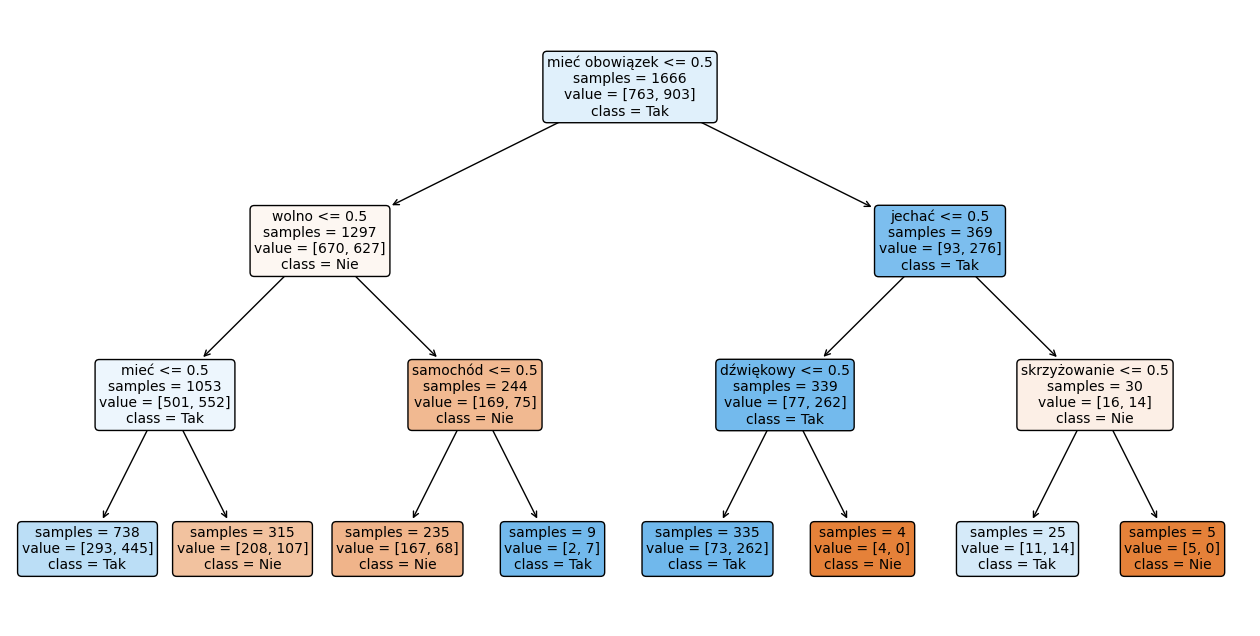

evaluation: {'accuracy': 0.67, 'precision': 0.66, 'recall': 0.81, 'f1_score': 0.72}
best parameters: {'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}


In [8]:
from sklearn.tree import DecisionTreeClassifier
# from modeller import DataTransformer, Optimizer, Modeler
from src.optimizer import Optimizer
from src.modeler import Modeler

import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree

input_parameters = {
    'max_depth': ['int', ('max_depth', 1, 3)],
    'min_samples_split': ['int', ('min_samples_split', 2, 20)],
    'min_samples_leaf': ['int', ('min_samples_leaf', 1, 20)],
    'criterion': ['categorical', ('criterion', ['gini', 'entropy', 'log_loss'])],
}

optimum = Optimizer(
    algorithm=DecisionTreeClassifier,
    input_parameters=input_parameters,
    X=X,
    y=y
)
best_params_shallow = optimum.optimize(n_trials=100)

model = Modeler(DecisionTreeClassifier)
results = model.fit_predict(X, y, model_params=best_params_shallow)
evaluation = model.evaluate(results['y_test'], results['y_pred'])

plt.figure(figsize=(16, 8))
plot_tree(model.classifier, feature_names=list(X.columns), class_names=['Nie', 'Tak'], filled=True, rounded=True, fontsize=10, impurity=False)
plt.show()

print(f"evaluation: {evaluation}")
print(f"best parameters: {best_params_shallow}")


Objaśnienie kilku rzeczy odnośnie wizualizacji:
* na samej górze mamy warunek. Przykładowo, jeśli warunkiem jest `mieć obowiązek <= 0.5` to możemy to interpretować jako *jeśli w pytaniu wystąpiło wrażenie `mieć obowiązek`*. Jeżeli warunek **jest** spełniony, to idziemy **w prawo**. Jeśli warunek **nie jest** spełniony, idziemy **w lewo**.
* `samples` to łączna liczba obserwacji w danym węźle. Liczba obserwacji w pierwszym węźle jest równa liczbie obserwacji w całym zbiorze, by z każdym poziomem się zmniejszać.
* `value` to liczba obserwacji należąca do różnych kategorii. Przykładowo, jeśli value=[93, 276], to oznacza że w danym węźle jest 93 obserwacji *Nie* i 276 *Tak*
* `class` pokazuje, która wartość w węźle występuje najczęściej

Może to brzmieć dość skomplikowanie, dlatego najlepiej będzie to pokazać na przykładzie. Weźmy pytanie 
```
Czy w tej sytuacji przed wykonaniem manewru skrętu w prawo, masz obowiązek zatrzymać się przed jezdnią poprzeczną?
```
które po przeprocesowaniu będzie brzmieć
```
sytuacja wykonać manewr skręt prawo mieć obowiązek zatrzymać jezdnia poprzeczny
```

Droga po drzewie będzie wyglądać następująco:
* **węzeł 1:** analizowane pytanie **zawiera** wyrażenie *masz obowiązek*, wobec czego idziemy **w prawo**
* **węzeł 2:** analizowane pytanie **nie zawiera** wyrażenia *jechać*, zatem idziemy **w lewo**
* **węzeł 3:** analizowane pytanie **nie zawiera** wyrażenia *dźwiękowy*, więc idziemy **w lewo**
* Dotarliśmy do liścia, w którym większość odpowiedzi stanowi **Tak** i jest to odpowiedź którą wybieramy

Dokładność naszego drzewa to 0.67,  co oznacza że prawdopodobieństwo udzielenia poprawnej odpowiedzi wynosi 67%, co przy progu zdawalności wynoszącym 80% może i nie jest najlepszym wynikiem, ale na pewno jest lepsze niż zaznaczanie zawsze odpowiedzi "Tak" (57% dokładności).

Pozostaje nam sprawdzić, co się stanie jeśli zwiększymy możliwą głębokość drzewa

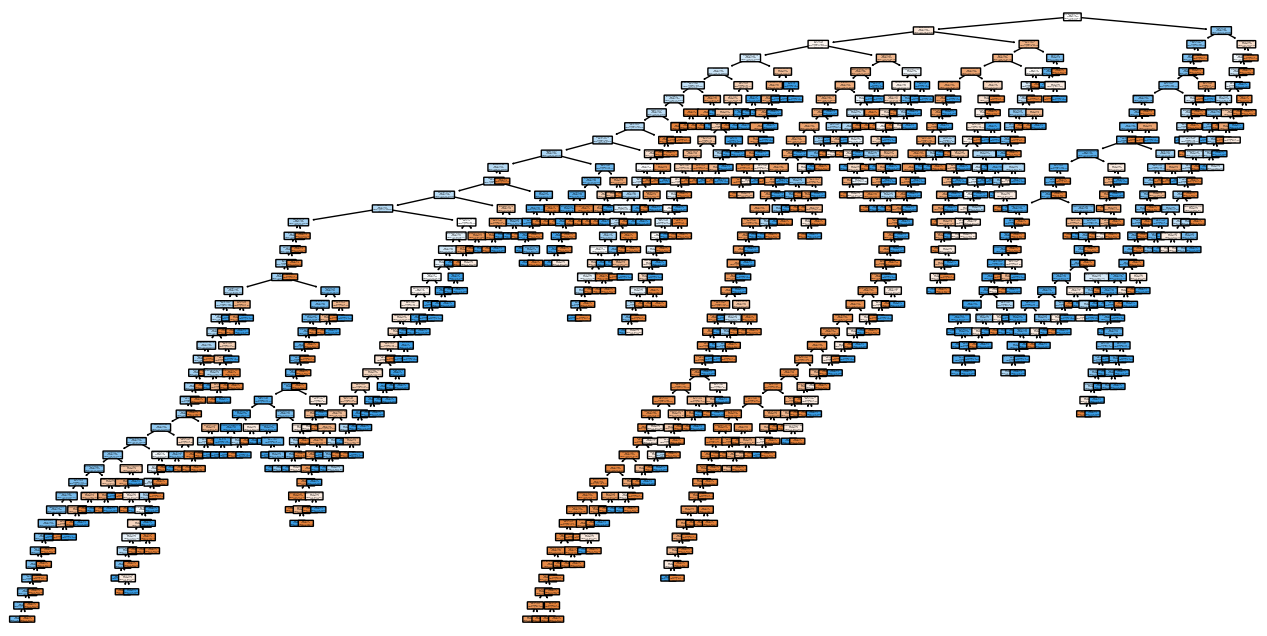

evaluation: {'accuracy': 0.96, 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.96}
best parameters: {'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'criterion': 'gini'}


In [9]:
input_parameters = {
    'max_depth': ['int', ('max_depth', 1, 50)],
    'min_samples_split': ['int', ('min_samples_split', 2, 20)],
    'min_samples_leaf': ['int', ('min_samples_leaf', 1, 20)],
    'class_weight': ['categorical', ('class_weight', [None, 'balanced'])],
    'criterion': ['categorical', ('criterion', ['gini', 'entropy', 'log_loss'])]
}

optimum = Optimizer(
    algorithm=DecisionTreeClassifier,
    input_parameters=input_parameters,
    X=X,
    y=y
)
best_params_deep = optimum.optimize(n_trials=100)

model = Modeler(DecisionTreeClassifier)
results = model.fit_predict(X, y, model_params=best_params_deep)

evaluation = model.evaluate(results['y_test'], results['y_pred'])

plt.figure(figsize=(16, 8))
plot_tree(model.classifier, feature_names=list(X.columns), class_names=['True', 'False'], filled=True, rounded=True)
plt.show()

print(f"evaluation: {evaluation}")

print(f"best parameters: {best_params_deep}")

Udało nam się osiągnąć dokładność na poziomie 96%, jednak rozmiar naszego drzewa decyzyjnego i złożoność modelu sugerują, że nie nadaje się on do użytku jako prosty algorytm dla osób, które nie posiadają konkretnej wiedzy i chcą uzyskać lepsze wyniki niż mogłyby uzyskać przez czyste zgadywanie.

Jednym z problemów, które się pojawiają, jest to, że testowaliśmy nasz model na tych samych danych, na których był uczony. Chociaż w niektórych przypadkach taki scenariusz, jak na przykład egzamin teoretyczny na prawo jazdy, może być odpowiedni (bo baza pytań jest znana), to dla większości modeli uczenia maszynowego celem jest dobre radzenie sobie z nowymi danymi, których wcześniej nie widziały.

Modele, które są testowane na tych samych danych, na których były uczone, mają tendencję do przeuczenia się (ang. *overfitting*). Przeuczenie modelu oznacza, że nauczył się on "za dobrze" dostosowywać się do danych treningowych. Mimo że może to sprawić, że model świetnie radzi sobie na tych konkretnych danych, to nie jest w stanie dobrze radzić sobie z nowymi i nieznanymi danymi.

Aby uniknąć przeuczenia, jedną z najprostszych i zarazem skutecznych technik jest podział zbioru danych na dwie części: zbiór treningowy i zbiór testowy. Na zbiorze treningowym model jest uczony, a na zbiorze testowym jest on oceniany. Zbiór testowy reprezentuje nowe dane dla modelu i ma na celu symulowanie sytuacji, w której model musi radzić sobie z danymi, których wcześniej nie widział.

Podział zbioru na dane treningowe i testowe może być przeprowadzony w różnych proporcjach, przy czym jednymi z często stosowanych są proporcje 80:20. Dzięki takiemu podziałowi, model jest w stanie nauczyć się na danych treningowych, a następnie przetestować swoje umiejętności na niezależnym zbiorze testowym, co pomaga w ocenie jego zdolności do generalizacji na nowe dane.

## Ewaluacja stworzonych modeli na danych testowych

In [10]:
model_params = {
    'shallow': best_params_shallow,
    'deep': best_params_deep
}
model_params

splits = {
    'no split': False,
    'split': True
}


model = Modeler(DecisionTreeClassifier)
for model_type, params in model_params.items():
    print(f"{model_type} model:")
    for split_type, split in splits.items():
        split_params = {'split': True, 'test_size': 0.2} if split else {}
    
        results = model.fit_predict(X, y, model_params=params, **split_params)
        accuracy = model.evaluate(results['y_test'], results['y_pred'])['accuracy']
        print(f"{split_type}, accuracy: {accuracy}")

shallow model:
no split, accuracy: 0.67
split, accuracy: 0.67
deep model:
no split, accuracy: 0.96
split, accuracy: 0.63


Z powyższego przykładu wynika, że model o nielimitowanej głębokości, optymalizowany wyłącznie na danych treningowych, osiąga dokładność wynoszącą 0.96. Jednakże, gdy ten sam model jest testowany na danych testowych, jego dokładność znacznie spada, osiągając wartość 0.63. W odróżnieniu od tego, model o niewielkiej głębokości zachowuje się podobnie zarówno w przypadku, gdy dane są podzielone na zbiory treningowe i testowe, jak i w przypadku, gdy takiego podziału nie ma (w rzeczywistości, w przypadku podziału, model o niewielkiej głębokości działa nawet lepiej niż model o większej głębokości).

Ten przykład jest doskonałą ilustracją zjawiska przeuczenia modelu. Model o maksymalnej głębokości 3, nawet jeśli jest ewaluowany na tych samych danych, na których był trenowany, ma niewielkie szanse na przeuczenie. Z kolei model bez ograniczenia głębokości może łatwo ulec przeuczeniu, szczególnie jeśli jest ewaluowany w sposób niewłaściwy. W kontekście tej obserwacji, podejmiemy się optymalizacji parametrów modelu drzewa decyzyjnego z uwzględnieniem podziału zbiorów danych.

## Optymalizacja modelu na danych testowych

In [11]:
optimum = Optimizer(
    algorithm=DecisionTreeClassifier,
    input_parameters=input_parameters,
    X=X,
    y=y,
    split=True,
    test_size=0.2
)
best_params = optimum.optimize(n_trials=100)

# %%

model = Modeler(DecisionTreeClassifier)
results = model.fit_predict(X, y, model_params=best_params, split=True, test_size=0.2)
evaluation = model.evaluate(results['y_test'], results['y_pred'])

print(f"evaluation: {evaluation}")
print(f"best parameters: {best_params}")

evaluation: {'accuracy': 0.71, 'precision': 0.71, 'recall': 0.85, 'f1_score': 0.77}
best parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'criterion': 'log_loss'}


Najlepszy model ewaluowany na danych testowych ma głębokość 20 (czyli zauważalnie mniej niż 50) i jego dokładność wynosi 0.71

# Word embeddings

Word embeddingi to technika reprezentacji słów w formie wektorów numerycznych w celu ułatwienia analizy języka naturalnego przez komputery. Każde słowo jest przypisywane do unikalnego wektora, w którym liczby odzwierciedlają jego semantykę i kontekst. Te wektory pozwalają modelom na lepsze zrozumienie podobieństw między słowami.


Przykładowo, weźmy sobie zestaw słów "król", "królowa", "mężczyzna" i "kobieta" Dzięki word embeddingom, komputer jest w stanie zrozumieć, że "król" i "królowa" są ze sobą powiązane, ponieważ odległość pomiędzy tymi wektorami jest niewielka. Co więcej, gdy wykonamy działanie na wektorach:
```
król – mężczyzna + kobieta
```
wyjdzie nam wynik zbliżony do "królowa". To pomaga w zadaniach takich jak przewidywanie kontekstu słów, tłumaczenie maszynowe i wiele innych analiz języka naturalnego. Podobne wektory można stworzyć również dla zdań, akapitów jak i dłuższych dokumentów.

Poniżej stworzę model embeddingowy przy użyciu modelu fasttext. Fasttext wykorzystuje sieci neuronowe do trenowania modelu na podstawie word embeddingu, posiada również możliwość automatycznego znalezienia optymalnych parametrów (*autotune*) i zostanie ona wykorzystana w celu optymalizacji modelu.

In [12]:
import fasttext
from sklearn.model_selection import train_test_split

from utils.functions import preprocess_for_fasttext

ft = preprocess_for_fasttext(questions)
train, test = train_test_split(ft, test_size=0.2, random_state=42)

train_filename = 'driving_license.train'
test_filename = 'driving_license.test'

train.to_csv(train_filename, index=False, header=False)
test.to_csv(test_filename, index=False, header=False)


model = fasttext.train_supervised(input=train_filename,  autotuneValidationFile=test_filename, autotuneDuration=100)

pred_fasttext = model.predict(test.str[13:].to_list())[0]
y_pred = pd.Series([pred[0][9:] for pred in pred_fasttext])

y_test = test.str[9:12].reset_index(drop=True)

model_ = Modeler()
model_.evaluate(y_test, y_pred, pos_label='tak')

Progress: 100.0% Trials:  329 Best score:  0.670659 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  1774
Number of labels: 2
Progress: 100.0% words/sec/thread:  410751 lr:  0.000000 avg.loss:  0.210151 ETA:   0h 0m 0s


{'accuracy': 0.66, 'precision': 0.71, 'recall': 0.69, 'f1_score': 0.7}

Dokładność modelu wynosi 0.66 - zauważalnie gorzej od drzew decyzyjnych, ale wciąż widać różnice pomiędzy zaznaczeniem wszystkich odpowiedzi na "tak".

# Wnioski i obserwacje


Po przeprowadzeniu eksperymentów z różnymi algorytmami, (m.in lasy losowe, XGBoost i SVM), okazało się, że pojedyncze drzewo decyzyjne osiągnęło najlepsze wyniki. 
Może to wydawać się zaskakujące, biorąc pod uwagę że drzewa decyzyjnie traktowane są jako względnie słabe predyktory, jednak biorąc pod uwagę niewielką liczbę obserwacji (1666) to zaskakująco maleje. Warto zwrócić uwagę, że w przypadku zbiorów danych o tak małej liczbie obserwacji, prostsze modele często sprawdzają się lepiej.

Co jest również interesujące, klasyczne metody reprezentacji tekstu, takie jak BOW, okazały się lepsze od embeddingów. Tutaj również rozmiar zbioru danych mógł wpłynąć na tę różnicę w wynikach, powodując niedostateczne wytrenowanie modelu embeddingowego.

Próbowałem także eksperymentować z zaawansowanymi technikami przetwarzania reprezentacji bag-of-words, takimi jak TF-IDF czy redukcja wymiarów, niestety bez odnotowania poprawy jakości modelu. To przykład, który potwierdza, że w niektórych przypadkach najprostsze rozwiązania okazują się najskuteczniejsze.